In [2]:
# IMAGE CLASSIFICATION WITH CNN - manuel downloading CIFAR10 iamges data and show image samples
#https://www.cs.toronto.edu/~kriz/cifar.html

import os
import torch
import torchvision
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import pickle
import platform

project_name = '05-cifar10-cnn-live'

#Download the dataset
def load_pickle(file):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return pickle.load(file)
    elif version[0] == '3':
        return pickle.load(file, encoding='bytes')
    raise ValueError("Invalid Python version: {}".format(version))

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % b)
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

# Specify the path to the extracted CIFAR-10 data
cifar10_dir = 'data/'

# Load the CIFAR-10 data
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

meta_file_path = 'data/batches.meta'

'''
for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = X_train[i].reshape(32, 32, 3)
    plt.imshow(img)  # Reshape to (32, 32, 3) for RGB images
    #plt.title(f"Class {y_train[i]}")
    plt.axis('off')  # Hide axes

plt.show()
'''

print(np.shape(X_train))
print(np.shape(y_train))

val_size = 5000
train_size = len(X_train) - val_size

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))

dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)



#Show 16 image samples from train dataset
def show_batch(dl):    
    imgs = []
    for ii in range (16):
        img = np.zeros((32,32,3))
        images, labels = dl.dataset[ii]
        img[:,:,0] = images[0:1024].reshape(32,32)/255 
        img[:,:,1] = images[1024:2048].reshape(32,32)/255
        img[:,:,2] = images[2048:3072].reshape(32,32)/255

        imgs.append(img)
    
    print("image shape: ", imgs[0].shape)

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Plot each image in its corresponding subplot
    for img, ax in zip(imgs, axs):
        ax.imshow(img)

    plt.show()

show_batch(train_dl)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_batch_1'

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


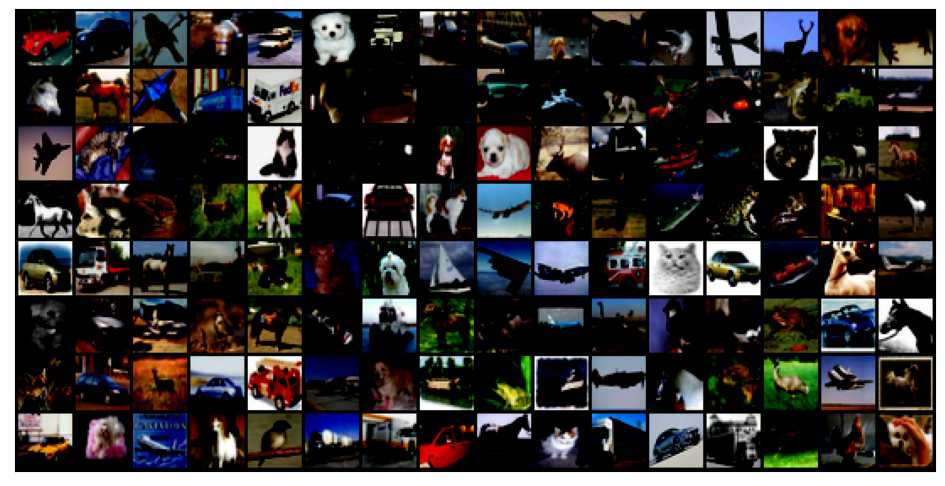

In [2]:
# IMAGE CLASSIFICATION WITH CNN

import os
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])

len(train_ds), len(val_ds)

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)



#Show 16 image samples from train dataset
def show_batch(dl):    
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break
    
show_batch(train_dl)

In [3]:
def apply_kernel(image,kernel):
    ri, ci = image.shape       #input image dimensions
    rk, ck = kernel.shape      #kernel dimensions
    ro,co = ri-rk+1, ci-ck+1   #output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j]=torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

for images, labels in train_dl:
    print("images_shape: ", images.shape)
    out = simple_model(images)
    print("out.shape: ",out.shape)
    break

images_shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 8, 16, 16])


In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()) / len(preds)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc }
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item() }
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #output: 64 x 16 x 16

            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)

        )

    def forward(self, xb):
        return self.network(xb)
    
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [5]:
for images, labels in train_dl:
    print('images.shape: ',images.shape)
    out = model(images)
    print('out.shape: ',out.shape)
    print('out[0]: ',out[0])
    break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 10])
out[0]:  tensor([-0.0252, -0.0284,  0.0103, -0.0525,  0.0119, -0.0075,  0.0263, -0.0019,
        -0.0294, -0.0034], grad_fn=<SelectBackward0>)


In [6]:
#Utilize GPU
import torch
print(torch.version.cuda)

def get_default_device():
    """Pick GPU available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print("Device is ", device)

def to_device(data,device):
    """Move tensors to chosen device"""
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

11.7
Device is  cuda


In [7]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model,device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()  #Switch to evaluation mode of the model for deterministic output, so dropout and batch norm removed
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)

    for epoch in range(epochs):
        #Training phase
        model.train() #Switch to training mode of the model, dropout and batch normalization start working
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        #Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [13]:
model = to_device(Cifar10CnnModel(), device)

evaluate(model, val_dl)

{'val_loss': 2.3034496307373047, 'val_acc': 0.10006892681121826}

In [14]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)





Epoch [0], train_loss: 1.6894, val_loss: 1.3138, val_acc: 0.5185
Epoch [1], train_loss: 1.1172, val_loss: 0.9707, val_acc: 0.6495
Epoch [2], train_loss: 0.8667, val_loss: 0.9189, val_acc: 0.6729
Epoch [3], train_loss: 0.7065, val_loss: 0.7687, val_acc: 0.7315
Epoch [4], train_loss: 0.5719, val_loss: 0.7865, val_acc: 0.7267
Epoch [5], train_loss: 0.4538, val_loss: 0.7033, val_acc: 0.7686
Epoch [6], train_loss: 0.3624, val_loss: 0.7498, val_acc: 0.7574
Epoch [7], train_loss: 0.2756, val_loss: 0.7811, val_acc: 0.7737
Epoch [8], train_loss: 0.2052, val_loss: 0.7820, val_acc: 0.7770
Epoch [9], train_loss: 0.1621, val_loss: 0.9381, val_acc: 0.7801


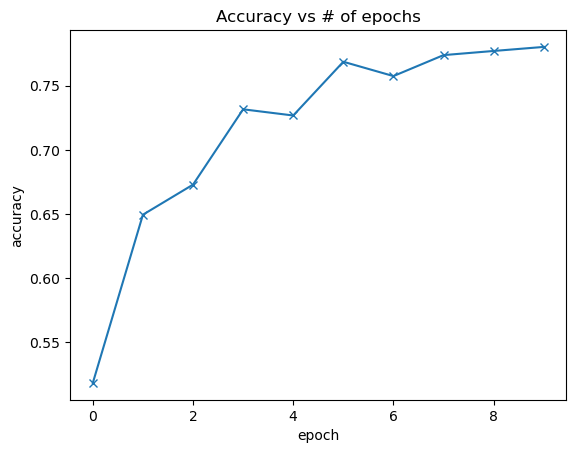

In [15]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs # of epochs')

plot_accuracies(history)

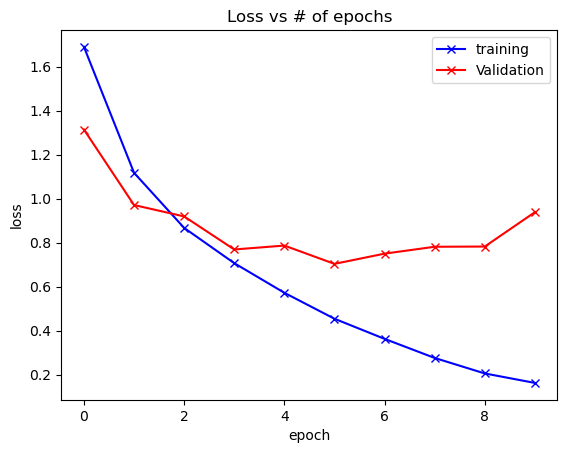

In [16]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'Validation'])
    plt.title('Loss vs # of epochs')

plot_losses(history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
Label:  airplane , Predicted:  airplane


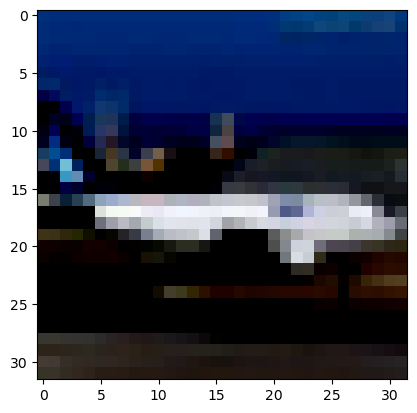

In [17]:
#After training and evaluation, let's do testing

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)

    yb = model(xb)

    _, preds = torch.max(yb, dim=1)

    return testset.classes[preds[0].item()]


img, label = testset[90]
print(img.shape)
plt.imshow(img.permute(1,2,0)) #Rearrange the dimensions of a tensor
print('Label: ', testset.classes[label], ', Predicted: ',predict_image(img, model))



In [19]:
print(testset.classes)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [26]:
#save the model
torch.save(model.state_dict(), 'cifar10-cnn.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
Label:  horse , Predicted:  horse


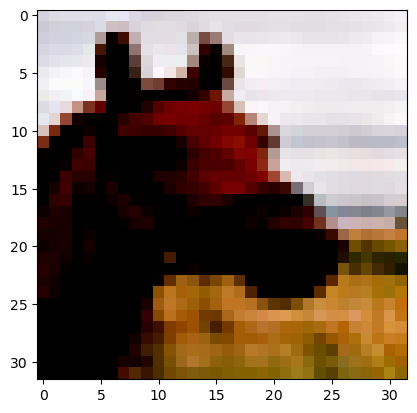

In [28]:
#Load saved model back in GPU

model2 = to_device(Cifar10CnnModel(), device)

# Load the state dictionary into your model
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

img, label = testset[99]
print(img.shape)
plt.imshow(img.permute(1,2,0)) #Rearrange the dimensions of a tensor
print('Label: ', testset.classes[label], ', Predicted: ',predict_image(img, model2))